# Assignment 3: Autoencoder

- Tasks:

1. classify handwritten digits: use simple supervised net


2. generate novel images of digits: use Variational Autoencoders and GANs


3. validation: use info theoretic measures to assess generative models


4. learn PyTorch

- networks:

    - feed-forward neural net

    - Autoencoder


- 2 datasets

    - MNIST
    
    - Retinal Bipolar

# utility

## import library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [110]:
!yes | pip install scprep phate pyemd -q 

In [112]:
from utility import show, interpolate, plot_inter_embed

import torch
from torch import optim, nn
from torch.utils.data import DataLoader 
import torchvision.transforms as transforms
import torchvision.transforms.functional as F 
import torchvision.datasets as datasets
from torchvision.utils import save_image, make_grid
import scprep
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import imageio
import os

In [113]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# classification of handwritten digits

- create a NN that classifies images of handwritten numbers by assigning them a category between 0-9
    
    

## FeedForwardNet

- TODO: fill in `FeedForwardNet.__init__` function in `ps3_functions.py`


1. create params for weight matrices and bias vectors that map 784D input to 10D output space

    remember multiply weights by input and add bias to product
    
    make sure dims for your weight matrix are correct
    
    use `torch.Tensor` operations
    

2. use batch matrix multiplication to process multiple data samples at once

    if you have an input x with shape batch_size x input_size,
    
    you can multiply each batch by a weight matrix simultaneously by taking $xW$, where W has shape input_size x output_size
    

3. add 1 hidden layer with 128 units between input and output by creating another weight and bias variable


4. initialize each variable with samples drawn from a uniform random distribution over interval

$$
\left [ -\frac{1}{\sqrt{\text{output size}}}, \frac{1}{\sqrt\text{output size}}  \right ]
$$


5. create a loss function set to categorical cross-entropy, initialize a stochastic gradient descent optimizer


6. fill in `forward()` function inside `FeedForwardNet` class to perform linear algebra that transforms 784D input into 10D output


7. fill in `train` function, completing TODOs to build a training loop and an evaluation function

    train model for 100 epochs with a batch size of 128,
    
    a learning rate 0.5
    

8. try training this without a non-linearity between layers (linear activation)

    then try add a sigmoid non-linearity both before and after hidden layer,
    
    record your test accuracy results for each in a table
    
    non-linearity: relu, softplus, elu, tanh
    

9. try adjust learning rate if your model isn't converging/improving in accuracy,

    may try increase number of epochs
    

10. try adjust width of hidden layers

    keep activation function that performs best
    
    remember to add results to your table
    

11. after train all of your models and select highest performer,

    use `torch.save` to preserve training for later use
    
    https://pytorch.org/tutorials/beginner/saving_loading_models.html
    
    

### model

In [ ]:
class FeedForwardNet(nn.Module):
    """ Simple feed forward network with one hidden layer."""
    def __init__(self, activation="linear", input_size=784, output_size=10, hidden_size=128): # initialize the model
        super(FeedForwardNet, self).__init__() # call for the parent class to initialize

        self.W1 = nn.Parameter(torch.zeros(input_size, hidden_size))
        torch.nn.init.uniform_(self.W1, -1/np.sqrt(hidden_size), 1/np.sqrt(hidden_size))
        
        # create a bias variable here
        self.b1 = nn.Parameter(torch.zeros(1, hidden_size))
        torch.nn.init.uniform_(self.b1, -1/np.sqrt(hidden_size), 1/np.sqrt(hidden_size))
        
        # Make sure to add another weight and bias vector to represent the hidden layer.
        self.W2 = nn.Parameter(torch.zeros(hidden_size, output_size))
        torch.nn.init.uniform_(self.W2, -1/np.sqrt(output_size), 1/np.sqrt(output_size))

        self.b2 = nn.Parameter(torch.zeros(1, output_size))
        torch.nn.init.uniform_(self.b2, -1/np.sqrt(output_size), 1/np.sqrt(output_size))

        if activation == "linear":
          self.activation = nn.Identity()
        elif activation == "sigmoid":
          self.activation = nn.Sigmoid()
        elif activation == "relu":
          self.activation = nn.ReLU()
        elif activation == "softplus":
          self.activation = nn.Softplus()
        elif activation == "elu":
          self.activation = nn.ELU()
        elif activation == "tanh":
          self.activation = nn.Tanh()

    def forward(self, x):
        """
        this is the function that will be executed when we call the feed-fordward network on data.
        INPUT:
            x, an MNIST image represented as a tensor of shape 784
        OUTPUT:
            predictions, a tensor of shape 10. If using CrossEntropyLoss, your model
            will be trained to put the largest number in the index it believes corresponds to the correct class.
        """
        # Be sure to add some type of nonlinearity to the output of the first layer, then pass it onto the hidden layer.
        H = self.activation(x @ self.W1 + self.b1) 
        
        predictions = H @ self.W2 + self.b2
        
        return predictions


### evaluate function

In [ ]:
def evaluate(model, evaluation_set, loss_fn, print_conf_matrix=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    labels = []
    preds = []

    total_loss = np.zeros(len(evaluation_set.dataset))

    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        # TODO: Fill in the rest of the evaluation function.

        num_correct = 0
        for i, (data, targets) in enumerate(evaluation_set):
          data = data.to(device)
          targets = targets.to(device)
          # run the model on the data
          model_input = data.reshape(-1, 784)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
          out = model(model_input)
          pred = out.argmax(dim=-1)

          loss = loss_fn(out, targets)

          total_loss[i] = loss.item()

          num_correct += int((pred == targets).sum()) 
          
          labels.extend(targets.detach().cpu().numpy())
          preds.extend(pred.detach().cpu().numpy())
          
        accuracy = num_correct / len(evaluation_set.dataset)

        loss = np.mean(total_loss)

    if print_conf_matrix:
      print(confusion_matrix(labels, preds))

    return accuracy, loss


### training function

In [ ]:
def train(model,loss_fn, optimizer, train_loader, test_loader, filename= "checkpoint.pt", print_conf_matrix=False, num_epochs: int = 100):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    :param filename: name for saved model, default to "checkpoint.pt", 
    :param print_conf_matrix: whether to print a confusion matrix, deafult to False
    """
    train_loss, test_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    best_test_acc = 0.
    best_epoch = None

    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:
          data = data.to(device)
          targets = targets.to(device)
          
          optimizer.zero_grad()

          # run the model on the data
          model_input = data.reshape(-1, 784)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
          out = model(model_input)

          # Calculate the loss
          loss = loss_fn(out,targets)

          # Find the gradients of our loss via backpropogation
          loss.backward()

          # Adjust accordingly with the optimizer
          optimizer.step()       
        
        train_acc, train_loss[epoch] = evaluate(model, train_loader, loss_fn)
        test_acc, test_loss[epoch] = evaluate(model, test_loader, loss_fn)

        # Give status reports every 100 epochs
        if epoch % 5==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            print(f" Train accuracy: {train_acc}. Test accuracy: {test_acc}") #TODO: implement the evaluate function to provide performance statistics during training.

        
        # Save checkpoint 
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch 

            with timer("Saving checkpoint..."):
                torch.save(model.state_dict(), filename)

    print("The best validation accuracy of {:.3f} occurred after epoch {}."
          "".format(best_test_acc, best_epoch))

    model.load_state_dict(torch.load(filename))

    evaluate(model, test_loader, loss_fn, print_conf_matrix=print_conf_matrix) 

    plt.plot(range(num_epochs), train_loss, 'g', label="Train loss")
    plt.plot(range(num_epochs), test_loss, 'b', label="Test loss")
    plt.title("Train loss and test loss")
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('feedforwardnet_mnist_train_test_loss.png') 
    plt.show()
    
    return model

### hyperparameter tuning

In [ ]:
# load training set
mnist_train = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor()) 
# load test set 
mnist_test = datasets.MNIST(root='data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor()) 

batch_size = 128                      
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

#### change activation function

try training this without a non-linearity between layers (linear activation)

then try add a sigmoid non-linearity both before and after hidden layer,

record your test accuracy results for each in a table

non-linearity: relu, softplus, elu, tanh

ReLU has best test accuracy of 0.980

- Linear: The best validation accuracy of 0.927 occurred after epoch 124. 

- ReLU: The best validation accuracy of 0.980 occurred after epoch 73. 

- SoftPlus: The best validation accuracy of 0.979 occurred after epoch 131. 

- ELU: The best validation accuracy of 0.979 occurred after epoch 140. 

- Tanh: The best validation accuracy of 0.980 occurred after epoch 147.

- Sigmoid: The best validation accuracy of 0.936 occurred after epoch 147.

 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.9097333333333333. Test accuracy: 0.9151
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9560333333333333. Test accuracy: 0.9548
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9683666666666667. Test accuracy: 0.9657
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 secon

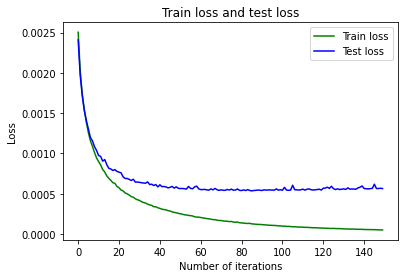

 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.8932. Test accuracy: 0.8982
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.92665. Test accuracy: 0.9257
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.004 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9454333333333333. Test accuracy: 0.9411
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...

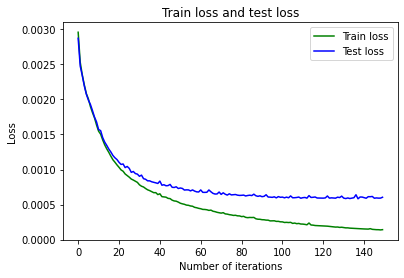

 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.9038. Test accuracy: 0.9056
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9384166666666667. Test accuracy: 0.9365
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9548833333333333. Test accuracy: 0.9516
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving ch

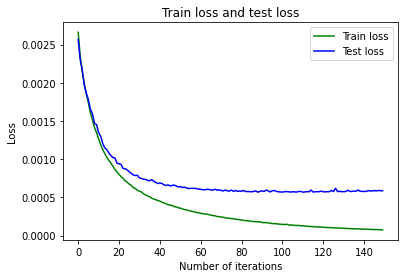

 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.9041166666666667. Test accuracy: 0.9085
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9422833333333334. Test accuracy: 0.9402
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9574166666666667. Test accuracy: 0.9539
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 secon

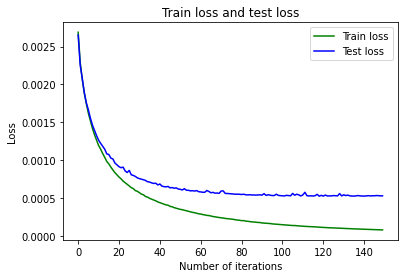

<Figure size 432x288 with 0 Axes>

In [ ]:
num_epochs = 150  
lr = 0.05
hidden_size = 128
activations = ["relu", "softplus", "elu", "tanh"]

for i, activation in enumerate(activations):
  # initialize the model
  model = FeedForwardNet(activation=activation, input_size=784, 
                 output_size=10, hidden_size=hidden_size).to(device)
  # initialize the optimizer, and set the learning rate
  SGD = torch.optim.SGD(model.parameters(), lr = lr) 

  # initialize the loss function. 
  loss_fn = torch.nn.CrossEntropyLoss()

  model = train(model, loss_fn, SGD, train_loader, test_loader, filename= f"checkpoint{i+1}.pt", 
      print_conf_matrix=False, num_epochs=num_epochs)  



 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.9034166666666666. Test accuracy: 0.9066
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9220666666666667. Test accuracy: 0.9225
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9256333333333333. Test accuracy: 0.9238
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 15. Progress: 10.0%. 
 Train accuracy: 0.9285333333333333. Test accuracy: 0.9243
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 20. Progress

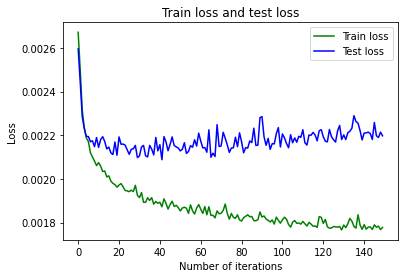

AttributeError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
# linear activation

num_epochs = 150  
lr = 0.05
hidden_size = 128
activation = "linear"

# initialize the model
model = FeedForwardNet(activation=activation, input_size=784, 
                 output_size=10, hidden_size=hidden_size).to(device)
# initialize the optimizer, and set the learning rate
SGD = torch.optim.SGD(model.parameters(), lr = lr) 

# initialize the loss function. 
loss_fn = torch.nn.CrossEntropyLoss()

model = train(model, loss_fn, SGD, train_loader, test_loader, filename= f"checkpoint{i}.pt", 
      print_conf_matrix=False, num_epochs=num_epochs)  



#### change learning rate

try adjust learning rate if your model isn't converging/improving in accuracy,

may try increase number of epochs

When learning rate is 0.5, the model has largest test accuracy 0.982 but the plot of training loss and test loss isn't smooth and test loss increases as number of epochs increases. But when learning rate is 0.01, the plot of training loss and test loss is more smooth and both training loss and test loss decreases and converges as number of epochs increases, given the still high test accuracy (0.974), I would choose learning rate to be 0.01.

-  0.01: The best validation accuracy of 0.974 occurred after epoch 148.

- 0.05: The best validation accuracy of 0.981 occurred after epoch 118.

- 0.1: The best validation accuracy of 0.981 occurred after epoch 88.

- 0.25: The best validation accuracy of 0.980 occurred after epoch 13.

- 0.5: The best validation accuracy of 0.982 occurred after epoch 48.

Model 1 learning rate: 0.01
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.8688333333333333. Test accuracy: 0.8753
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.91985. Test accuracy: 0.9235
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9336. Test accuracy: 0.9334
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 

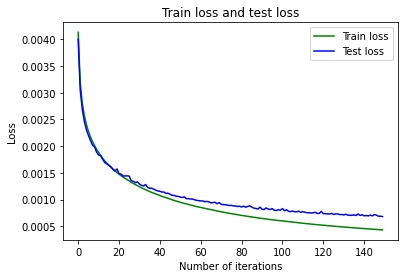

Model 2 learning rate: 0.05
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.91025. Test accuracy: 0.9146
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9544333333333334. Test accuracy: 0.9516
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9671833333333333. Test accuracy: 0.9616
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time ela

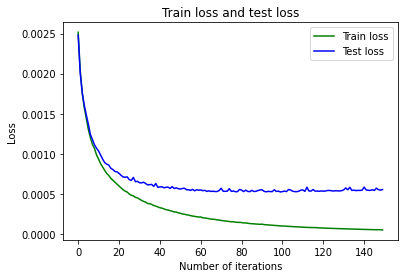

Model 3 learning rate: 0.1
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.9236333333333333. Test accuracy: 0.9244
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9696666666666667. Test accuracy: 0.9643
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9802666666666666. Test accuracy: 0.9706
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 15. Progress: 10.0

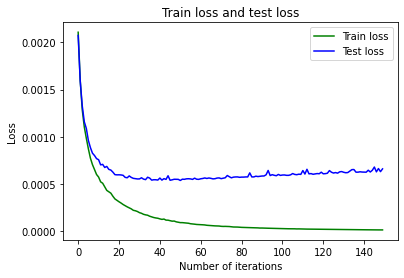

Model 4 learning rate: 0.25
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.9494666666666667. Test accuracy: 0.9464
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9838333333333333. Test accuracy: 0.9759
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9914666666666667. Test accuracy: 0.9794
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 15. Progress: 10.0%. 
 Train accuracy: 0.9953833333333333. Test accuracy: 0.9781
 EPOCH 20. Progress: 13.333333333333334%. 
 Train accuracy: 0.9981166666666667. Test accuracy: 0.9796

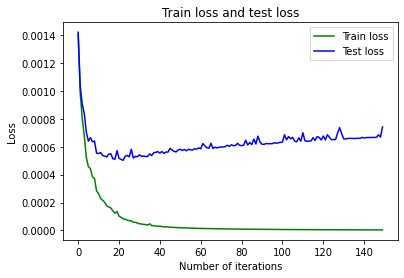

Model 5 learning rate: 0.5
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.9521833333333334. Test accuracy: 0.9512
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9906833333333334. Test accuracy: 0.9781
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9965666666666667. Test accuracy: 0.9787
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 15. Progress: 10.0%. 
 Train accuracy: 0.9993666666666666. Test accuracy: 0.9809
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 20. Progress: 13.333333333333334%. 
 Tra

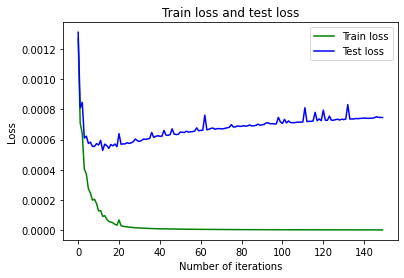

<Figure size 432x288 with 0 Axes>

In [ ]:
num_epochs = 150  
lrs = [0.01, 0.05, 0.1, 0.25, 0.5]
hidden_size = 128
activation = "relu"

for i, lr in enumerate(lrs):

  print(f"Model {i+1} learning rate: {lr}")
  # initialize the model 
  model = FeedForwardNet(activation=activation, input_size=784, 
                 output_size=10, hidden_size=hidden_size).to(device)
  # initialize the optimizer, and set the learning rate
  SGD = torch.optim.SGD(model.parameters(), lr = lr) 

  # initialize the loss function. 
  loss_fn = torch.nn.CrossEntropyLoss()

  model = train(model, loss_fn, SGD, train_loader, test_loader, filename= f"checkpoint{i}.pt", 
      print_conf_matrix=False, num_epochs=num_epochs)



#### change hidden size

try adjust width of hidden layers

keep activation function that performs best

remember to add results to your table

hidden size 512 has best performance, test loss also decreases when training loss decreases.

- 32: The best validation accuracy of 0.973 occurred after epoch 15. Loss plot not good

- 64: The best validation accuracy of 0.981 occurred after epoch 39. Loss plot not good

- 128: The best validation accuracy of 0.980 occurred after epoch 22.

- 256: The best validation accuracy of 0.982 occurred after epoch 23.

- 512: The best validation accuracy of 0.981 occurred after epoch 183.

model 1 hidden size 32
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.9386333333333333. Test accuracy: 0.9367
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.001 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9758. Test accuracy: 0.967
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.001 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9841166666666666. Test accuracy: 0.9704
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 15. Progress: 10.0%. 
 Train accuracy: 0.9883833333333333. Test accuracy: 0.9727
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
 EPOCH 20. Progress: 13.333333333333334%. 
 Train accuracy: 0.9879333333333333. Test accuracy: 0.9685
 EPOCH 25. Progre

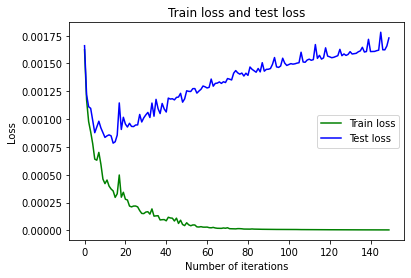

model 2 hidden size 64
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.94475. Test accuracy: 0.9441
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.001 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9850166666666667. Test accuracy: 0.9752
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9919. Test accuracy: 0.9756
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 15. Progress: 10.0%. 
 Train accuracy: 0.99705. Test accuracy: 0.978
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 20. Progress: 13.333333333333334%. 
 Train accuracy: 0.9989166666666667. Test accuracy: 0.9795
Saving checkpoint...
Done. Time elapsed

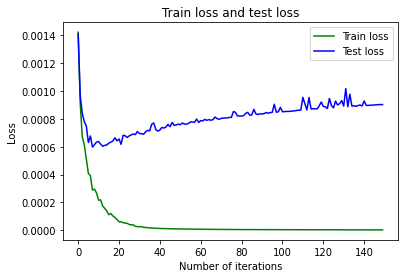

model 3 hidden size 128
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.95465. Test accuracy: 0.9541
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9875. Test accuracy: 0.9741
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9956833333333334. Test accuracy: 0.9763
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 15. Progress: 10.0%. 
 Train accuracy: 0.9989. Test accuracy: 0.9789
Saving checkpoint...
Done. Tim

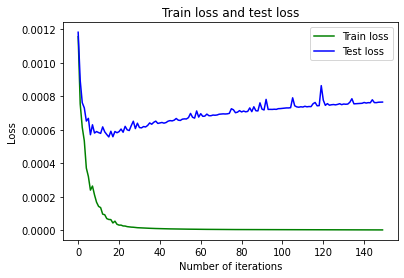

model 4 hidden size 256
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.9637666666666667. Test accuracy: 0.9593
Saving checkpoint...
Done. Time elapsed: 0.004 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9840666666666666. Test accuracy: 0.9713
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9966333333333334. Test accuracy: 0.9808
Saving checkpoint...
Done. Time elapsed: 0.004 seconds
 EPOCH 15. Progress: 10.0%. 
 Train accuracy: 0.99965. Test accuracy: 0.9806
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
 EPOCH 20. Progress: 13.333333333333334%. 
 Train accuracy: 0.9999333333333333. Test accuracy: 0.9816
Saving checkpoint...
Done. Time elapsed: 0.004 seconds
Saving checkpo

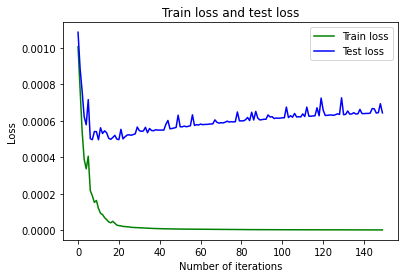

model 5 hidden size 512
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.9609166666666666. Test accuracy: 0.9561
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.9909666666666667. Test accuracy: 0.9775
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.9990166666666667. Test accuracy: 0.981
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
 EPOCH 15. Progress: 10.0%. 
 Train accuracy: 0.99985. Test accuracy: 0.9817
Saving checkpoint...
Done. Time elapsed: 0.004 seconds
Saving checkpoint...
Done. Time elapsed: 0.004 seconds
 EPOCH 

In [ ]:
num_epochs = 150  
lr = 0.01 
hidden_sizes = [32, 64, 128, 256, 512]
activation = "relu"

for i, hidden_size in enumerate(hidden_sizes):
  print(f"model {i+1} hidden size {hidden_size}")
  # initialize the model 
  model = FeedForwardNet(activation=activation, input_size=784, 
                 output_size=10, hidden_size=hidden_size).to(device)
  # initialize the optimizer, and set the learning rate
  SGD = torch.optim.SGD(model.parameters(), lr = lr) 

  # initialize the loss function. 
  loss_fn = torch.nn.CrossEntropyLoss()

  model = train(model, loss_fn, SGD, train_loader, test_loader, filename= f"checkpoint{i}.pt", 
      print_conf_matrix=False, num_epochs=num_epochs) 

model 5 hidden size 512
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.9028666666666667. Test accuracy: 0.909
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.004 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
 EPOCH 5. Progress: 2.5%. 
 Train accuracy: 0.9424833333333333. Test accuracy: 0.9408
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.004 seconds
 EPOCH 10. Progress: 5.0%. 
 Train accuracy: 0.9546166666666667. Test accuracy: 0.9513
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Saving checkpoint...
Done. Time elapsed: 0.005 seconds
Sav

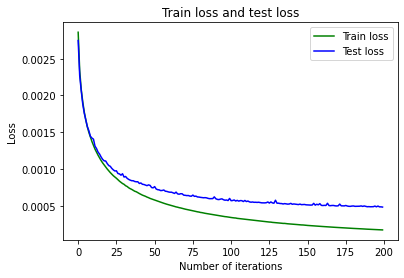

<Figure size 432x288 with 0 Axes>

In [ ]:
# hidden_size = 512
num_epochs = 200  
lr = 0.01 
hidden_size = 512
activation = "relu"

print(f"model 5 hidden size {hidden_size}")
# initialize the model 
model = FeedForwardNet(activation=activation, input_size=784, 
                 output_size=10, hidden_size=hidden_size).to(device)
# initialize the optimizer, and set the learning rate
SGD = torch.optim.SGD(model.parameters(), lr = lr) 

# initialize the loss function. 
loss_fn = torch.nn.CrossEntropyLoss()

model = train(model, loss_fn, SGD, train_loader, test_loader, filename= f"checkpoint5.pt", 
      print_conf_matrix=False, num_epochs=num_epochs) 

#### sigmoid function both before and after hidden layer

The best validation accuracy of 0.936 occurred after epoch 147.

In [ ]:
num_epochs = 150  
batch_size = 128
lr = 0.05
hidden_size = 128
# initialize the model
model = FeedForwardNet().to(device)
# initialize the optimizer, and set the learning rate
SGD = torch.optim.SGD(model.parameters(), lr = lr) # This is absurdly high.

adam = torch.optim.Adam(model.parameters(), lr = lr)
# initialize the loss function. You don't want to use this one, so change it accordingly
loss_fn = torch.nn.CrossEntropyLoss()

 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.6248. Test accuracy: 0.6287
Saving checkpoint...
Done. Time elapsed: 0.008 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 5. Progress: 3.3333333333333335%. 
 Train accuracy: 0.8237666666666666. Test accuracy: 0.8332
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
 EPOCH 10. Progress: 6.666666666666667%. 
 Train accuracy: 0.8641. Test accuracy: 0.8718
Saving checkpoint...
Done. Time elapsed: 0.003 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...
Done. Time elapsed: 0.002 seconds
Saving checkpoint...


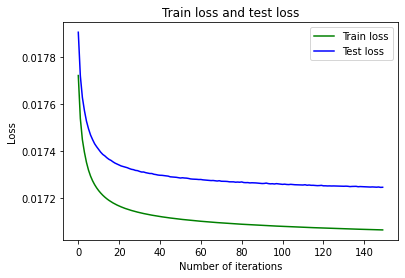

FeedForwardNet()

In [ ]:
# "checkpoint1.pt": 24min, train Feedforward Net
# hyperparams:  num_epochs = 150, batch_size = 128, lr = 0.5, hidden_size = 128, num_hidden_layers = 1
# The best validation accuracy of 0.936 occurred after epoch 147.
model = train(model,loss_fn, SGD, train_loader, test_loader, filename= "checkpoint1.pt", 
      print_conf_matrix=True, num_epochs=num_epochs) 

## discussion

- what percentage classification accuracy does this net achieve?

The net achieves average 98% of classification accuracy

- create a plot of training and test error vs number of iteartions


- how many iterations are sufficient to reach good performance?

I train the Feedforward Network using 150 iterations, from the plot of training and test error vs number of iteartions we can see 150 epochs are enough.

- print confusion matrix showing which digits were misclassified


- what they were misclassified as


- what numbers are frequently confused with one another by your model?


In [ ]:
 # i-th row and j-th column entry indicates the number of samples 
 # with true label being i-th class and predicted label being j-th class.
 
true\predicted 0     1    2    3    4    5    6    7    8    9
    
0          [[ 961    0    0    2    0    5    9    1    2    0]
1           [   0 1113    3    3    1    1    4    2    8    0]
2           [  12    1  939   12   15    0   11   15   26    1]
3           [   1    0   19  934    1   22    2   12   14    5]
4           [   2    2    3    0  929    0    8    2    5   31]
5           [   7    2    2   39    7  792   13    4   20    6]
6           [  11    3    3    2   12   12  911    1    3    0]
7           [   4    9   23    3    9    1    0  956    3   20]
8           [   5    4    3   14    8   11    9    8  909    3]
9           [  13    7    0   11   34    7    1   16    8  912]]

Digit 5 is misclassified as digit 3 by 39 times, which is the most frequent misclassification; digit 9 is misclassified as digit 4 by 34 times; digit 2 is misclassified as digit 8 by 26 times; digit 7 is misclassified as digit 2 by 23 times and misclassified as digit 9 by 20 times; digit 5 is misclassified as digit 8 by 20 times. It makes sense because these digits are similar in some features.


- experiment with learning rate, optimizer and activation function of your network


- report best accuracy and briefly describe training scheme that reached this accuracy

learning rate: 0.01, optimizer: SGD, activation function: ReLU, hidden size: 512, test accuracy 98.1%

# Autoencoder

## MNIST

- TODO: 

1. fill in `Autoencoder` class 

  - create a stack of layers of shape: 784-1000-500-250-2-250-500-1000-784
  
  - use `nn.Linear` function to manage creation of weight and bias params

  - between each layer, use a tanh activation

  - change activation function going to middle (2D) layer to linear, keep rest as tanh
    
  - use sigmoid activation function on output of last hidden layer


2. adapt your training function for autoencoder


3.use same batch size = 128, number of epochs = 100
    

4. but use ADAM optimizer instead of gradient descent
    

5. use mean squared error for reconstruction loss
    
    
6. after train model, plot 2D embeddings of 1000 digits, colored by image labels


7. produce side-by-side plots of one original and reconstructed sample of each digit (0-9),

    use `save_image` function from `torchvision.utils`
    

8. for fun: locate embeddings of 2 distinct images,

    interpolate between them to produce some intermediate point in latent space
    
    visualize this point in 2D embedding
    
    then, run your decoder on this fabricated "embedding" to see if it output looks anything like a handwritten digit
    
    you may try interpolate between and within several different classes

### model

In [ ]:
# Autoencoder for MNIST
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.en_lin1 = nn.Linear(784, 1000)
        self.en_lin2 = nn.Linear(1000, 500)
        self.en_lin3 = nn.Linear(500, 250)
        self.en_lin4 = nn.Linear(250, 2)

        self.de_lin1 = nn.Linear(2, 250)
        self.de_lin2 = nn.Linear(250, 500)
        self.de_lin3 = nn.Linear(500, 1000)
        self.de_lin4 = nn.Linear(1000, 784)


    def encode(self, x):
        x = self.en_lin1(x)
        x = torch.tanh(x) 
        x = self.en_lin2(x)
        x = torch.tanh(x)
        x = self.en_lin3(x)
        x = torch.tanh(x)
        x = self.en_lin4(x) 

        return x

    def decode(self, z):
        z = self.de_lin1(z) 
        z = torch.tanh(z)  
        z = self.de_lin2(z)
        z = torch.tanh(z)
        z = self.de_lin3(z)
        z = torch.tanh(z)
        z = self.de_lin4(z)  
        z = torch.sigmoid(z) 

        return z  

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

### evaluate function

In [ ]:
# evaluate function for Autoencoder and MINIST: 
# for MSE loss, now the target is input rather than label
def evaluate(model, evaluation_set, loss_fn):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    batch_loss = np.zeros(len(evaluation_set.dataset))

    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.

        for i, (data, _) in enumerate(evaluation_set):
          data = data.to(device)
          model_input = data.reshape(-1, 784)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
          out = model(model_input)
          loss = loss_fn(out, model_input)
          batch_loss[i] = loss.item()

    return np.mean(batch_loss)


### training function

In [ ]:
# train function for Autoencoder and MINIST: 
# for MSE loss, now the target is input rather than label
def train(model,loss_fn, optimizer, scheduler,  train_loader, test_loader, filename= "checkpoint.pt", num_epochs: int = 100):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """

    train_loss, test_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    best_epoch = None

    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, _ in train_loader:
          data = data.to(device)
          optimizer.zero_grad()

          # run the model on the data
          model_input = data.reshape(-1, 784)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
          out = model(model_input)

          # Calculate the loss
          loss = loss_fn(out, model_input)

          # Find the gradients of our loss via backpropogation
          loss.backward()

          # Adjust accordingly with the optimizer
          optimizer.step()       
        
        train_loss[epoch] = evaluate(model, train_loader, loss_fn)
        test_loss[epoch] = evaluate(model, test_loader, loss_fn)
        scheduler.step()

        # Give status reports every 100 epochs
        if epoch % 5==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            print(f" Train loss: {train_loss[epoch]}. Test loss: {test_loss[epoch]}")
        
        # Save checkpoint
        if epoch == 0:
          min_test_loss = test_loss[epoch]
          best_epoch = epoch

          with timer("Saving checkpoint..."):
                torch.save(model.state_dict(), filename)

        elif test_loss[epoch] < min_test_loss:
            min_test_loss = test_loss[epoch]
            best_epoch = epoch 

            with timer("Saving checkpoint..."):
                torch.save(model.state_dict(), filename)

    print("The minimum test loss of {:.6f} occurred after epoch {}."
           "".format(min_test_loss, best_epoch))

    model.load_state_dict(torch.load(filename))


    plt.plot(range(num_epochs), train_loss, 'g', label="Train loss")
    plt.plot(range(num_epochs), test_loss, 'b', label="Test loss")
    plt.title("Training loss and test loss")
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    plt.savefig('autoencoder_mnist_test_loss.png') 


    return model

### training

In [ ]:
num_epochs = 100  
batch_size = 128
lr = 0.003

In [ ]:
# initialize Autoencoder model
model = Autoencoder().to(device) 
 
# initialize Adan optimizer, and set the learning rate
adam = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.StepLR(adam, step_size=5, gamma=0.1)
  
# initialize Mean Squared Error loss function
loss_fn = torch.nn.MSELoss() 

 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.00041258895384768646. Test loss: 0.000417373401299119
Saving checkpoint...
Done. Time elapsed: 0.027 seconds
Saving checkpoint...
Done. Time elapsed: 0.026 seconds
Saving checkpoint...
Done. Time elapsed: 0.023 seconds
Saving checkpoint...
Done. Time elapsed: 0.024 seconds
Saving checkpoint...
Done. Time elapsed: 0.024 seconds
 EPOCH 5. Progress: 5.0%. 
 Train loss: 0.00028832707523057855. Test loss: 0.0002946347342804074
Saving checkpoint...
Done. Time elapsed: 0.024 seconds
Saving checkpoint...
Done. Time elapsed: 0.022 seconds
Saving checkpoint...
Done. Time elapsed: 0.024 seconds
Saving checkpoint...
Done. Time elapsed: 0.023 seconds
Saving checkpoint...
Done. Time elapsed: 0.023 seconds
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002769520299198727. Test loss: 0.0002840573240071535
Saving checkpoint...
Done. Time elapsed: 0.024 seconds
Saving checkpoint...
Done. Time elapsed: 0.023 seconds
Saving checkpoint...
Done. Time elapsed: 0.023 se

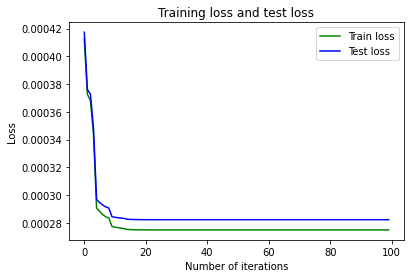

<Figure size 432x288 with 0 Axes>

In [ ]:
# "checkpoint5.pt": train Autoencoder on MNIST
# use adaptive learning rate 
# 17 min, The minimum test loss of 0.000279 occurred after epoch 42.   
model = train(model, loss_fn, adam, scheduler, train_loader, test_loader, filename= "checkpoint5.pt", num_epochs=num_epochs) 

### side-by-side plots

In [ ]:
# load trained Autoencoder 
model = Autoencoder().to(device)
checkpoint = torch.load("checkpoint5.pt") 
model.load_state_dict(checkpoint)  

<All keys matched successfully>

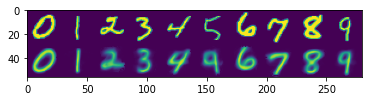

In [ ]:
# produce side-by-side plots of one original and reconstructed sample of each digit (0-9)
comparisons = []
for data, targets in test_loader:
  for i in range(10):
    original = data[targets==i][0].to(device)
    reconstructed = model(original.reshape(-1, 784)) 
    comparisons.append(torch.cat([original.view(28, 28), reconstructed.view(28, 28)]))

  break  

comparisons = torch.cat(comparisons, dim=-1)
plt.imshow(comparisons.detach().cpu().numpy()) 
save_image(comparisons.cpu(), "comparison.png")

### 2D embeddings of 1k digits

In [ ]:
# load trained Autoencoder
model = Autoencoder().to(device)
checkpoint = torch.load("checkpoint2.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

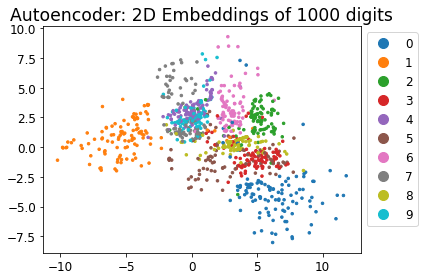

In [ ]:
data_loader = torch.utils.data.DataLoader(mnist_train, batch_size = 1000, shuffle = True)

with torch.no_grad():
    for data, targets in data_loader:
        data = data.to(device)
        model_input = data.reshape(-1, 784)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
        embeddings = model.encode(model_input).detach().cpu().numpy()
        labels = targets.numpy()
        break

scprep.plot.scatter2d(embeddings, c = labels, 
                          title="Autoencoder: 2D Embeddings of 1000 digits",
                          legend_anchor=(1,1))  

### fabricated embedding

In [ ]:
def interpolate(embeddings, n=10, label1=0, label2=0):
    """
    generate `n` fabricated embeddings by interpolating between embeddings of 2 distinct images

    @params:
    embeddings: embeddings of images generated by Autoencoder or Variational Autoencoder 
    n: number of fabricated embeddings generated, default to 10 
    label1: label of first image class, default to 0 
    label2: label of second image class, default to 0
    """
   

    # select the first image of label 1
    img1 = embeddings[labels == label1][0]

    if label1 == label2:
      
      # select the 25th image of label 1
      img2 = embeddings[labels == label1][25] 

    else:

      # select the first image of label 2
      img2 = embeddings[labels == label2][0] 

    # concatenate 2 images to a numpy array 2 x 2
    imgs = np.stack((img1, img2)) 

    # interpolate `n` fabricated embeddings
    fabricated_embeddings = np.zeros((n, embeddings.shape[1])) 
    for i in range(n):
        # generate weight matrix 1 x `embeddings.shape[1]`
        w1 = np.random.uniform()
        weight = np.stack((w1, 1-w1))
        fabricated_embeddings[i] = weight @ imgs

    fabraicated_imgs = model.decode(torch.Tensor(fabricated_embeddings).to(device)) 

    # reshape the image tensors into a grid
    fabraicated_imgs = make_grid(fabraicated_imgs.view(-1, 1, 28, 28).detach())

    show(fabraicated_imgs)

    # save the generated torch tensor images
    save_image(fabraicated_imgs, "fabraicated_imgs.png")

    return img1, img2, fabricated_embeddings

    # fabraicated_imgs = imageio.imread("/content/fabraicated_imgs.png")

    # show(fabraicated_imgs)


In [ ]:
def plot_inter_embed(embeddings, img1, img2, inter_embed, classes="between"):

    # plot 2D Embeddings of 1000 digits, colored by image labels
    fig, ax = plt.subplots()
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1],  c=labels, s=1)
    legend = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Class",
                    bbox_to_anchor=(1, 1))

    # plot 2D original embeddings
    scatter = ax.scatter(img1[0], img1[1],  c='r')
    scatter = ax.scatter(img2[0], img2[1],  c='r')

    # plot 2D interpolated embeddings
    scatter = ax.scatter(inter_embed[:, 0], inter_embed[:,1],  c='b', s=12)

    ax.add_artist(legend)

    if classes == "between":
      plt.title(f"Autoencoder: Fabricated 2D Embeddings between digit {label1} and digit {label2}")

    elif classes == "within":
      plt.title(f"Autoencoder: Fabricated 2D Embeddings within digits {label1}")

    plt.show()

In [ ]:
# load trained Autoencoder
model = Autoencoder().to(device) 
checkpoint = torch.load("checkpoint2.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

#### between classes

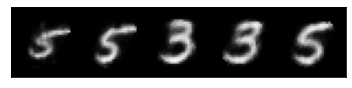

In [ ]:
label1 = 3
label2 = 1

# interpolate an embedding from digit 3 and digit 1
img1, img2, inter_embed = interpolate(embeddings, n=5, label1=label1, label2=label2) 

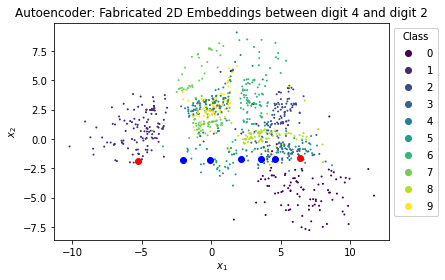

In [ ]:
plot_inter_embed(embeddings, img1, img2, inter_embed, classes="between")

#### within classes

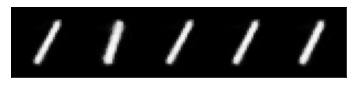

In [ ]:
label1 = 1
label2 = 1

img1, img2, inter_embed = interpolate(embeddings, n=5, label1=label1, label2=label2) 

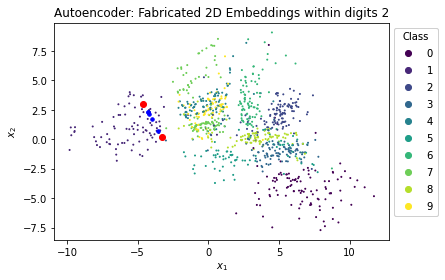

In [ ]:
plot_inter_embed(embeddings, img1, img2, inter_embed, classes="within")

### discussion

- Do the colors easily separate, are they all clumped together?

    which numbers are frequently embedded close together?
    
    what does this mean?

Clusters of digit 1 (orange), digit 6 (pink), digit 2 (dark green), and digit 0 (dark blue) are easily separte, but the clusters of digit 7 (gray), digit 4 (purple), digit 9 (light blue) have overlaps, also, clusters of digit 8 (light green), digit 3 (red), digit 5 (brown) have overlaps. 

Digits 4, 7 and 9 are embedded close together, digits 3, 5 and 8 are embedded close together.

This means these handwritten digits are similar in some features that the network learned (e.g., perhaps the shape).

- How realistic were images you generated by interpolating between points in latent space?


- Can you think of a better way to generate images with an autoencoder?

## Retinal Bipolar

use an autoencoder to embed 26 distinct classes of retinal bipolar cells into a 2D space where class separation is evident

1. run PCA on retinal bipolar data to reduce number of features to a more manageable quantity (perhaps 784)

    subsampling shouldn't be necessary unless you have an old computer,
    
    since Autoencoders are quite fast


2. create a training and testing split of data (choose an 80-20 split) and generate minibatches from training data

    shuffle the order of points between epochs
    

3. start with same autoencoder architecture as last section,

    change last layer's activation to a linear (instead of a sigmoid activation)
    

4. after train model, plot 2D embedding of test set,

    color with ground truth cluster labels

### model

In [ ]:
# Autoencoder for Retinal Bipolar:
# change last layer's activation to a linear instead of sigmoid
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.en_lin1 = nn.Linear(784, 1000)
        # define additional layers here
        self.en_lin2 = nn.Linear(1000, 500)
        self.en_lin3 = nn.Linear(500, 250)
        self.en_lin4 = nn.Linear(250, 2)

        self.de_lin1 = nn.Linear(2, 250)
        self.de_lin2 = nn.Linear(250, 500)
        self.de_lin3 = nn.Linear(500, 1000)
        self.de_lin4 = nn.Linear(1000, 784)


    def encode(self, x):
        x = self.en_lin1(x)
        # ... additional layers, plus possible nonlinearities.
        x = torch.tanh(x) 
        x = self.en_lin2(x)
        x = torch.tanh(x)
        x = self.en_lin3(x)
        x = torch.tanh(x)
        x = self.en_lin4(x) 

        return x

    def decode(self, z):
        # ditto, but in reverse
        z = self.de_lin1(z) 
        z = torch.tanh(z)  
        z = self.de_lin2(z)
        z = torch.tanh(z)
        z = self.de_lin3(z)
        z = torch.tanh(z)
        z = self.de_lin4(z)  

        return z  

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)



### evaluate function

In [ ]:
# evaluate function for Autoencoder and Retinal Bipolar: 
# don't need to change input shape to (-1, 784)
def evaluate(model, evaluation_set, loss_fn):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """

    batch_loss = np.zeros(len(evaluation_set.dataset))

    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        # TODO: Fill in the rest of the evaluation function.

        for i, (data, targets) in enumerate(evaluation_set):
          # run the model on the data
          model_input = data.to(device)
          out = model(model_input)
          loss = loss_fn(out, model_input)
          batch_loss[i] = loss.item()

    return np.mean(batch_loss)


### training function

In [ ]:
# train function for Autoencoder and Retinal Bipolar: 
# don't need to change input shape
def train(model,loss_fn, optimizer, train_loader, test_loader, filename= "checkpoint.pt", num_epochs: int = 100):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """

    train_loss, test_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    best_epoch = None

    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:

          optimizer.zero_grad()

          # run the model on the data
          model_input = data.to(device)
          out = model(model_input)

          # Calculate the loss
          loss = loss_fn(out, model_input)

          # Find the gradients of our loss via backpropogation
          loss.backward()

          # Adjust accordingly with the optimizer
          optimizer.step()       
        
        train_loss[epoch] = evaluate(model, train_loader, loss_fn)
        test_loss[epoch] = evaluate(model, test_loader, loss_fn)

        scheduler.step() 
        
        # Give status reports every 100 epochs
        if epoch % 5==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            print(f" Train loss: {train_loss[epoch]}. Test loss: {test_loss[epoch]}")
        
        # Save checkpoint
        if epoch == 0:
          min_test_loss = test_loss[epoch]
          best_epoch = epoch

          with timer("Saving checkpoint..."):
                torch.save(model.state_dict(), filename)

        elif test_loss[epoch] < min_test_loss:
            min_test_loss = test_loss[epoch]
            best_epoch = epoch 

            with timer("Saving checkpoint..."):
                torch.save(model.state_dict(), filename)

    print("The minimum test loss of {:.3f} occurred after epoch {}."
           "".format(min_test_loss, best_epoch))

    model.load_state_dict(torch.load(filename))


    plt.plot(range(num_epochs), train_loss, 'g', label="Train loss")
    plt.plot(range(num_epochs), test_loss, 'b', label="Test loss")
    plt.title("Training loss and test loss")
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show() 
    plt.savefig('autoencoder_retinal_train_test_loss.png')


    return model

### training

In [ ]:
with open('/content/drive/MyDrive/retinal-bipolar-data.pickle', 'rb') as f:
    data = pd.read_pickle(f)

with open('/content/drive/MyDrive/retinal-bipolar-metadata.pickle', 'rb') as f:
    metadata = pd.read_pickle(f)

# use PCA to reduce dim of data to 784
data = scprep.reduce.pca(data, n_components=784, method='dense')

In [ ]:
data.shape, metadata.shape

((21552, 784), (21552, 3))

In [ ]:
# split dataset into training data and test data with ratio 8:2
mask = np.random.rand(len(data)) < 0.8 

train_data = torch.Tensor(data[mask].values.astype(np.float32))
train_label = torch.Tensor(metadata[mask]['CLUSTER'].values.astype(np.float32))

test_data = torch.Tensor(data[~mask].values.astype(np.float32))
test_label = torch.Tensor(metadata[~mask]['CLUSTER'].values.astype(np.float32))

ret_train = torch.utils.data.TensorDataset(train_data, train_label)

ret_test = torch.utils.data.TensorDataset(test_data, test_label) 

In [ ]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(ret_train, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(ret_test, batch_size=batch_size)

In [ ]:
len(train_loader.dataset), len(test_loader.dataset) 

(17241, 4311)

In [ ]:
lr = 0.003

# initialize Autoencoder model
model = Autoencoder().to(device)

# initialize the optimizer, and set the learning rate
adam = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.StepLR(adam, step_size=5, gamma=0.1)

# initialize the Mean Squared Error loss function. 
loss_fn = torch.nn.MSELoss()

 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.027082823260561592. Test loss: 0.02734004607805656
Saving checkpoint...
Done. Time elapsed: 0.037 seconds
Saving checkpoint...
Done. Time elapsed: 0.032 seconds
Saving checkpoint...
Done. Time elapsed: 0.040 seconds
Saving checkpoint...
Done. Time elapsed: 0.029 seconds
Saving checkpoint...
Done. Time elapsed: 0.025 seconds
 EPOCH 5. Progress: 5.0%. 
 Train loss: 0.026066668120305062. Test loss: 0.026389186881695177
Saving checkpoint...
Done. Time elapsed: 0.031 seconds
Saving checkpoint...
Done. Time elapsed: 0.025 seconds
Saving checkpoint...
Done. Time elapsed: 0.028 seconds
Saving checkpoint...
Done. Time elapsed: 0.031 seconds
Saving checkpoint...
Done. Time elapsed: 0.069 seconds
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.025589022418751696. Test loss: 0.025945390136301087
Saving checkpoint...
Done. Time elapsed: 0.022 seconds
Saving checkpoint...
Done. Time elapsed: 0.022 seconds
Saving checkpoint...
Done. Time elapsed: 0.022 seconds
Sa

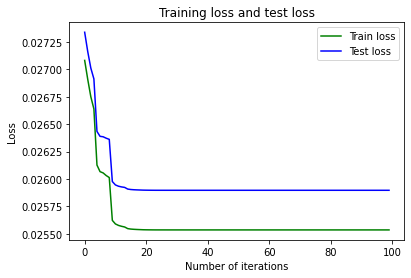

<Figure size 432x288 with 0 Axes>

In [ ]:
# "checkpoint3.pt": training Autoencoder on Retinal Bipolar data
# 1 min
# The minimum test loss of 0.026 occurred after epoch 37.

num_epochs = 100  

model = train(model,loss_fn, adam, train_loader, test_loader, filename="checkpoint3.pt", num_epochs=num_epochs) 


### visualize 2D Embeddings of test set

In [ ]:
# load trained Autoencoder
model = Autoencoder().to(device)
checkpoint = torch.load("checkpoint3.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        embeddings = model.encode(data).detach().cpu().numpy()
        labels = targets.numpy()
        break 


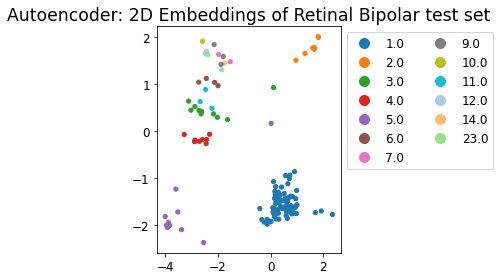

In [ ]:
# plot 2D Embeddings of test set, color by ground truth cluster labels
scprep.plot.scatter2d(embeddings, c = labels, 
                          title="Autoencoder: 2D Embeddings of Retinal Bipolar test set",
                          legend_anchor=(1,1)) 

### discussion

- How many clusters are visible in the embedding?


- Do they correspond to cluster labels?

I can see 6 clusters in the embeddings. They correspond to cluster label 1.0 (blue), label 5.0 (purple), label 2.0 (orange), label 4.0 (red), label 3.0 (dark green), label 6.0 (brown)